1. Скачать данные о рынке недвижимости c открытого соревнования Сбербанка по машинному обучению https://www.kaggle.com/c/sberbank-russian-housing-market/data. Скачиваем только файлы train.csv.zip, macro.csv.zip и сливаем  в один датафрейм. Описание колонок - data_dictionary.txt
2. Провести чистку данных (пропуски данных, неинформативные признаки, аномалии, оцифровка текстовых столбцов и т.п.)
3. Провести Exploratory Data Analysis. Проанализировать переменные, влияющие на зависимую переменную - стоимость недвижимости price_doc.
4. Разделить датасет на обучающие и тестовую  выборки.
5. Обучить регрессионную модель предсказывать стоимость недвижимости в зависимости от разных факторов и выявить показатели качества модели на обучающей и тестовой выборке.
6. Реализовать методы feature engineering с целью повышения метрик качества модели.


In [61]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.utils import shuffle


In [3]:
macro = pd.read_csv('macro.csv.zip')
macro.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,brent,net_capital_export,gdp_annual,gdp_annual_growth,average_provision_of_build_contract,average_provision_of_build_contract_moscow,rts,micex,micex_rgbi_tr,micex_cbi_tr,deposits_value,deposits_growth,deposits_rate,mortgage_value,mortgage_growth,mortgage_rate,grp,grp_growth,income_per_cap,real_dispos_income_per_cap_growth,salary,salary_growth,fixed_basket,retail_trade_turnover,retail_trade_turnover_per_cap,retail_trade_turnover_growth,labor_force,unemployment,employment,...,sewerage_share,gas_share,hot_water_share,electric_stove_share,heating_share,old_house_share,average_life_exp,infant_mortarity_per_1000_cap,perinatal_mort_per_1000_cap,incidence_population,rent_price_4+room_bus,rent_price_3room_bus,rent_price_2room_bus,rent_price_1room_bus,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,load_of_teachers_preschool_per_teacher,child_on_acc_pre_school,load_of_teachers_school_per_teacher,students_state_oneshift,modern_education_share,old_education_build_share,provision_doctors,provision_nurse,load_on_doctors,power_clinics,hospital_beds_available_per_cap,hospital_bed_occupancy_per_year,provision_retail_space_sqm,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38807.2,-0.078209,5.0,NaN,NaN,NaN,NaN,NaN,7484970,NaN,NaN,142968,NaN,13.72,8375.8638,NaN,30789.2,0.038,38410.5,NaN,11443.63,2882.4169,251.484,106.8,6436.244,0.018,0.69,...,99.6,44.4,95.7,55.0,99.9,0.3,74.2,6.1,5.87,696.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.477765,"45,713",1356.112607,NaN,NaN,NaN,18.0,99.4,7872.848285,162.9,NaN,NaN,NaN,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
1,2010-01-02,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38807.2,-0.078209,5.0,NaN,NaN,NaN,NaN,175.15,7484970,NaN,NaN,142968,NaN,13.72,8375.8638,NaN,30789.2,0.038,38410.5,NaN,11443.63,2882.4169,251.484,106.8,6436.244,0.018,0.69,...,99.6,44.4,95.7,55.0,99.9,0.3,74.2,6.1,5.87,696.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.477765,"45,713",1356.112607,NaN,NaN,NaN,18.0,99.4,7872.848285,162.9,NaN,NaN,NaN,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
2,2010-01-03,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38807.2,-0.078209,5.0,NaN,NaN,NaN,NaN,178.66,7484970,NaN,NaN,142968,NaN,13.72,8375.8638,NaN,30789.2,0.038,38410.5,NaN,11443.63,2882.4169,251.484,106.8,6436.244,0.018,0.69,...,99.6,44.4,95.7,55.0,99.9,0.3,74.2,6.1,5.87,696.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.477765,"45,713",1356.112607,NaN,NaN,NaN,18.0,99.4,7872.848285,162.9,NaN,NaN,NaN,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
3,2010-01-04,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.905,43.4054,80.12,NaN,38807.2,-0.078209,5.0,NaN,NaN,NaN,NaN,183.44,7484970,NaN,NaN,142968,NaN,13.72,8375.8638,NaN,30789.2,0.038,38410.5,NaN,11443.63,2882.4169,251.484,106.8,6436.244,0.018,0.69,...,99.6,44.4,95.7,55.0,99.9,0.3,74.2,6.1,5.87,696.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.477765,"45,713",1356.112607,NaN,NaN,NaN,18.0,99.4,7872.848285,162.9,NaN,NaN,NaN,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN
4,2010-01-05,76.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.836,42.9600,80.59,NaN,38807.2,-0.078209,5.0,NaN,NaN,NaN,NaN,183.44,7484970,NaN,NaN,142968,NaN,13.72,8375.8638,NaN,30789.2,0.038,38410.5,NaN,11443.63,2882.4169,251.484,106.8,6436.244,0.018,0.69,...,99.6,44.4,95.7,55.0,99.9,0.3,74.2,6.1,5.87,696.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.477765,"45,713",1356.112607,NaN,NaN,NaN,18.0,99.4,7872.848285,162.9,NaN,NaN,NaN,690.0,6221.0,527.0,0.41,993.0,NaN,NaN,63.03,22825.0,NaN


In [4]:
import zipfile
z = zipfile.ZipFile('train.csv.zip')

z.namelist()

['train.csv', '__MACOSX/', '__MACOSX/._train.csv']

In [5]:
data = pd.read_csv(z.open('train.csv'))
data.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,...,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Bibirevo,6.407578e+06,155572,0.189727,0.000070,9576,5001.0,5,10309,11065.0,5,0,240.0,1,0,7,3,no,0,16,1,no,no,no,no,no,no,no,...,639.68,1079.37,859.52,5,21,22,16,3,1,0,2,4,0,0,21,1,13.09,13.31,29,807385,52,4036616,152,708.57,1185.71,947.14,12,39,48,40,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Nagatinskij Zaton,9.589337e+06,115352,0.372602,0.049637,6880,3119.0,5,7759,6237.0,8,0,229.0,1,0,6,1,yes,1,3,0,no,no,no,no,no,no,no,...,631.03,1086.21,858.62,1,11,11,4,2,1,0,1,7,0,6,19,1,10.26,27.47,66,2690465,40,2034942,177,673.81,1148.81,911.31,9,49,65,36,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Tekstil'shhiki,4.808270e+06,101708,0.112560,0.118537,5879,1463.0,4,6207,5580.0,7,0,1183.0,1,0,5,1,no,0,0,1,no,no,no,yes,no,no,no,...,697.44,1192.31,944.87,2,9,17,9,3,1,0,0,11,0,0,20,6,13.69,21.58,43,1478160,35,1572990,122,702.68,1196.43,949.55,10,29,45,25,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Mitino,1.258354e+07,178473,0.194703,0.069753,13087,6839.0,9,13670,17063.0,10,0,NaN,1,0,17,6,no,0,11,4,no,no,no,no,no,no,no,...,718.75,1218.75,968.75,0,5,14,10,3,0,0,1,2,0,0,18,3,14.18,3.89,8,244166,22,942180,61,931.58,1552.63,1242.11,4,7,21,15,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,Basmannoe,8.398461e+06,108171,0.015234,0.037316,5706,3240.0,7,6748,7770.0,9,0,562.0,4,2,25,2,no,0,10,93,no,no,no,yes,yes,no,no,...,853.03,1410.45,1131.74,63,266,267,262,149,57,4,70,121,1,40,77,5,8.38,10.92,689,8404624,114,3503058,2283,853.88,1411.45,1132.66,143,566,578,552,319,108,17,135,236,2,91,195,14,16331452


In [6]:
# склеиваем датафреймы

macro['timestamp'] = pd.to_datetime(macro['timestamp'])
data['timestamp'] = pd.to_datetime(data['timestamp'])

df = data.merge(macro, on = 'timestamp', how = 'inner')
df.shape

(30471, 391)

In [7]:
  pd.set_option('display.max_rows', 1000)
  df.isna().mean().sort_values(ascending = False)

provision_retail_space_modern_sqm             0.975288
provision_retail_space_sqm                    0.816481
students_reg_sports_share                     0.554659
museum_visitis_per_100_cap                    0.554659
theaters_viewers_per_1000_cap                 0.554659
load_of_teachers_preschool_per_teacher        0.554659
hospital_beds_raion                           0.473926
build_year                                    0.446490
state                                         0.444980
cafe_sum_500_max_price_avg                    0.435857
cafe_sum_500_min_price_avg                    0.435857
cafe_avg_price_500                            0.435857
material                                      0.314135
kitch_sq                                      0.314135
num_room                                      0.314135
max_floor                                     0.314135
preschool_quota                               0.219487
school_quota                                  0.219389
cafe_avg_p

In [8]:
df.dtypes

id                                                     int64
timestamp                                     datetime64[ns]
full_sq                                                int64
life_sq                                              float64
floor                                                float64
max_floor                                            float64
material                                             float64
build_year                                           float64
num_room                                             float64
kitch_sq                                             float64
state                                                float64
product_type                                          object
sub_area                                              object
area_m                                               float64
raion_popul                                            int64
green_zone_part                                      float64
indust_part             

In [9]:
# удаляем неинформативные признаки
df = df.drop(['id', 'ID_big_road1', 'ID_big_road2', 'ID_bus_terminal', 'ID_metro', 'ID_railroad_station_avto', 'ID_railroad_station_walk', 'ID_railroad_terminal'], axis=1)

In [10]:
# поиск дубликатов
df.duplicated().sum()

10

In [11]:
# удаление дупликатов
df = df.drop_duplicates()

In [12]:
# проверяем пропуски в таргете
df['price_doc'].isna().sum()

0

In [13]:
df[['full_sq', 'life_sq', 'kitch_sq']].isna().sum()

full_sq        0
life_sq     6376
kitch_sq    9567
dtype: int64

In [14]:
df[['full_sq', 'life_sq', 'kitch_sq']].describe()

,full_sq,life_sq,kitch_sq
count,30461.000000,24085.000000,20894.000000
mean,54.211877,34.399128,6.398535
std,38.034562,52.285018,28.268262
min,0.000000,0.000000,0.000000
25%,38.000000,20.000000,1.000000
50%,49.000000,30.000000,6.000000
75%,63.000000,43.000000,9.000000
max,5326.000000,7478.000000,2014.000000


In [15]:
# скорректировать отдельные пропущенные значения
df['life_sq'] = np.where(df['life_sq'].isna(), df['full_sq'] - df['kitch_sq'], df['life_sq'])
df['life_sq'] = np.where(df['life_sq']==0, df['full_sq'] - df['kitch_sq'], df['life_sq'])

df['kitch_sq'] = np.where(df['kitch_sq'].isna(), df['full_sq'] - df['life_sq'], df['kitch_sq'])
df['kitch_sq'] = np.where(df['kitch_sq']==0, df['full_sq'] - df['life_sq'], df['kitch_sq'])

df['full_sq'] = np.where(df['full_sq']==0, df['kitch_sq'] + df['life_sq'], df['full_sq'])

df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

(30461, 383)

In [16]:
# удаляем пропуски
df = df.dropna(subset = ['life_sq', 'kitch_sq'])
df.shape

(28216, 383)

In [17]:
df[['full_sq', 'life_sq', 'kitch_sq']].describe()

,full_sq,life_sq,kitch_sq
count,28216.000000,28216.000000,28216.000000
mean,53.836086,37.810462,9.440424
std,38.928202,49.851869,41.447789
min,0.000000,0.000000,-720.000000
25%,38.000000,21.000000,1.000000
50%,48.000000,32.000000,8.000000
75%,63.000000,45.000000,11.000000
max,5326.000000,7478.000000,5304.000000


In [18]:
# оставим только больше 0
df = df[df['full_sq']>0]
df = df[df['life_sq']>0]
df = df[df['kitch_sq']>0]

In [19]:
# оценка доли жилой площади
(df['life_sq']/df['full_sq']).median()

0.6052631578947368

In [20]:
# корректировка значения жилой площади
df['life_sq'] = np.where(df['life_sq'] >= df['full_sq'], df['full_sq']*0.61, df['life_sq'])

In [21]:
# оценка доли площади кухни
(df['kitch_sq']/df['full_sq']).median()

0.15730337078651685

In [22]:
# корректировка значения площади кухни
df['kitch_sq'] = np.where(df['kitch_sq'] >= df['full_sq'], df['full_sq']*0.61, df['kitch_sq'])

In [23]:
df['kitch_sq'] = np.where(df['kitch_sq'] >= df['life_sq'], df['life_sq']*(0.61/0.16), df['kitch_sq'])

In [24]:
df[['full_sq', 'life_sq', 'kitch_sq']].describe()

,full_sq,life_sq,kitch_sq
count,25955.000000,25955.000000,25955.000000
mean,53.408361,34.248702,12.206977
std,39.697694,18.422964,18.004584
min,1.000000,0.610000,1.000000
25%,38.000000,20.000000,5.000000
50%,47.000000,30.000000,8.000000
75%,63.000000,43.000000,12.000000
max,5326.000000,602.000000,358.375000


In [25]:
# делаем тримминг fullsq
df['full_sq'].quantile(0.02)

29.0

In [26]:
df['full_sq'].quantile(0.98)

109.0

In [27]:
df = df[df['full_sq'].between(29,109)]
df.shape

(25034, 383)

In [28]:
# рассчитаем цену на площадь
df['price_per_sq'] = df['price_doc']/df['full_sq']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


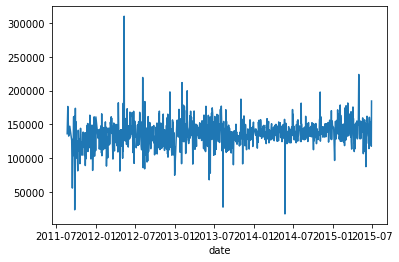

In [29]:
df['date'] = df['timestamp'].dt.date
agg = df.groupby('date')['price_per_sq'].mean()
agg.plot();

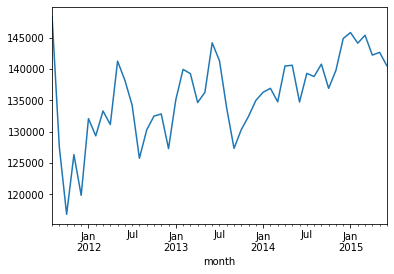

In [30]:
df['month'] = df['timestamp'].dt.to_period('M')
agg2 = df.groupby('month')['price_per_sq'].mean()
agg2.plot();

In [31]:
agg2

month
2011-08    148358.413133
2011-09    127499.060532
2011-10    116822.632344
2011-11    126341.788003
2011-12    119849.541816
2012-01    132090.046043
2012-02    129342.972140
2012-03    133309.676002
2012-04    131149.376361
2012-05    141255.836649
2012-06    138224.311450
2012-07    134220.272000
2012-08    125758.923061
2012-09    130278.091263
2012-10    132492.535486
2012-11    132829.957844
2012-12    127307.081771
2013-01    135099.244789
2013-02    139942.788666
2013-03    139271.604473
2013-04    134659.084362
2013-05    136285.864495
2013-06    144186.882684
2013-07    141323.450324
2013-08    133700.323472
2013-09    127343.135053
2013-10    130338.703047
2013-11    132470.153912
2013-12    134989.273267
2014-01    136302.540165
2014-02    136923.747198
2014-03    134765.140718
2014-04    140480.959951
2014-05    140601.804917
2014-06    134740.305102
2014-07    139305.047227
2014-08    138806.137570
2014-09    140775.957995
2014-10    136917.200403
2014-11    139795.8

In [32]:
price_index = agg2/agg2[-1]
price_index.head()

month
2011-08    1.055800
2011-09    0.907353
2011-10    0.831374
2011-11    0.899117
2011-12    0.852915
Freq: M, Name: price_per_sq, dtype: float64

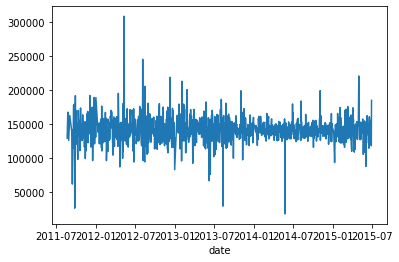

In [33]:
dic = price_index.to_dict()
df['price_index'] = df['month'].map(dic)

df['price_per_sq_const'] = df['price_per_sq']/df['price_index']

agg = df.groupby('date')['price_per_sq_const'].mean()
agg.plot()

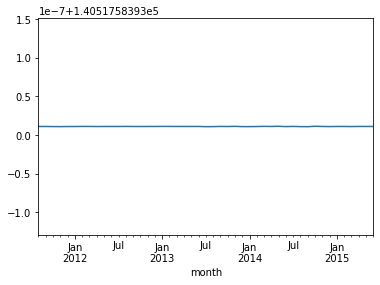

In [34]:
agg2 = df.groupby('month')['price_per_sq_const'].mean()
agg2.plot()

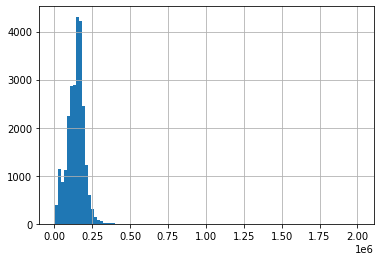

In [35]:
df['price_per_sq_const'].hist(bins = 100);

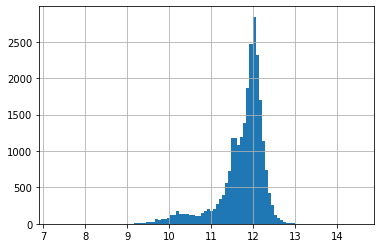

In [36]:
np.log1p(df['price_per_sq_const']).hist(bins = 100);

In [37]:
df['target'] = np.log1p(df['price_per_sq_const'])
df = df.drop(['price_doc', 'price_per_sq', 'price_per_sq_const', 'date', 'month'], axis=1)

In [38]:
# создаем новые фичи по колонке времени
df['dow'] = df['timestamp'].dt.dayofweek
df['dom'] = df['timestamp'].dt.day
df['doy'] = df['timestamp'].dt.dayofyear
df['month'] = df['timestamp'].dt.month
df['woy'] = df['timestamp'].dt.weekofyear
df = df.drop('timestamp', axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [39]:
# удаляем колонки с пропусками 50% и более
col_list = []

for column in df.columns:
  if df[column].isna().mean() >= 0.5:
    col_list.append(column)

col_list

['load_of_teachers_preschool_per_teacher',
 'provision_retail_space_sqm',
 'provision_retail_space_modern_sqm',
 'theaters_viewers_per_1000_cap',
 'museum_visitis_per_100_cap',
 'students_reg_sports_share']

In [40]:
df = df.drop(columns = col_list, axis=1)

In [41]:
# работа с категориальными переменными
for column in df.select_dtypes(include='object'):
  print(column)
  print('Uniq values:', df[column].nunique())
  print('==============================================')
  print(df[column].unique())
  print('==============================================')

product_type
Uniq values: 2
['Investment' 'OwnerOccupier']
sub_area
Uniq values: 146
['Bibirevo' 'Nagatinskij Zaton' "Tekstil'shhiki" 'Mitino' 'Nizhegorodskoe'
 'Koptevo' 'Kuncevo' 'Kosino-Uhtomskoe' 'Zapadnoe Degunino' 'Lefortovo'
 "Mar'ino" "Kuz'minki" 'Nagornoe' "Gol'janovo" 'Vnukovo'
 'Severnoe Tushino' "Chertanovo Central'noe" 'Juzhnoe Tushino'
 'Fili Davydkovo' 'Otradnoe' 'Novo-Peredelkino' 'Bogorodskoe'
 'Jaroslavskoe' 'Strogino' 'Hovrino' "Moskvorech'e-Saburovo"
 'Staroe Krjukovo' 'Ljublino' 'Veshnjaki' 'Danilovskoe' 'Caricyno'
 'Preobrazhenskoe' "Kon'kovo" 'Brateevo' 'Vostochnoe Izmajlovo'
 'Vyhino-Zhulebino' 'Donskoe' 'Novogireevo' 'Sokol' 'Kurkino' 'Izmajlovo'
 'Severnoe Medvedkovo' 'Rostokino' 'Orehovo-Borisovo Severnoe'
 'Ochakovo-Matveevskoe' 'Taganskoe' 'Dmitrovskoe'
 'Orehovo-Borisovo Juzhnoe' 'Teplyj Stan' 'Juzhnoe Butovo' 'Basmannoe'
 'Babushkinskoe' 'Pokrovskoe Streshnevo' 'Obruchevskoe' 'Filevskij Park'
 'Troparevo-Nikulino' 'Severnoe Butovo' 'Hamovniki' 'Solncevo'


In [42]:
# бинаризация категориальных столбцов
bin_cols = ['culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line']
df[bin_cols] = df[bin_cols].applymap(lambda x: 1 if x == 'yes' else 0)

dic = {'Investment': 1, 'OwnerOccupier': 0}
df['product_type'] = df['product_type'].map(dic)

In [43]:
# преобразвание порядкового категориального столбца
dic2 = {'poor': 1, 'satisfactory': 2, 'good': 3, 'excellent': 4, 'no data': np.nan}
df['ecology'] = df['ecology'].map(dic2)

In [44]:
# преобразловане текстовых столбцов к числовому типу
df['child_on_acc_pre_school']  = df['child_on_acc_pre_school'].replace('#!', np.nan)

lst2 = ['child_on_acc_pre_school', 'modern_education_share', 'old_education_build_share']

for column in lst2:
  df[column] = df[column].str.replace(',', '.').astype(float)

In [45]:
# преобразование столбца с high cardinality
df['sub_area'].value_counts()

Poselenie Vnukovskoe              930
Nekrasovka                        852
Poselenie Sosenskoe               696
Poselenie Voskresenskoe           601
Poselenie Moskovskij              593
Tverskoe                          511
Mar'ino                           503
Mitino                            495
Krjukovo                          466
Juzhnoe Butovo                    435
Otradnoe                          345
Solncevo                          330
Nagatinskij Zaton                 316
Poselenie Filimonkovskoe          307
Ljublino                          291
Gol'janovo                        286
Bogorodskoe                       282
Zapadnoe Degunino                 279
Nagornoe                          265
Tekstil'shhiki                    262
Birjulevo Vostochnoe              261
Vyhino-Zhulebino                  258
Strogino                          249
Poselenie Shherbinka              246
Izmajlovo                         244
Zjuzino                           237
Horoshevo-Mn

In [46]:
lst3 = (df['sub_area'].value_counts() >= 100).loc[lambda x: x==True].index.tolist()


df['sub_area_new'] = np.where(df['sub_area'].isin(lst3), df['sub_area'], 'Other')
df['sub_area_new'].value_counts()

Other                        2227
Poselenie Vnukovskoe          930
Nekrasovka                    852
Poselenie Sosenskoe           696
Poselenie Voskresenskoe       601
Poselenie Moskovskij          593
Tverskoe                      511
Mar'ino                       503
Mitino                        495
Krjukovo                      466
Juzhnoe Butovo                435
Otradnoe                      345
Solncevo                      330
Nagatinskij Zaton             316
Poselenie Filimonkovskoe      307
Ljublino                      291
Gol'janovo                    286
Bogorodskoe                   282
Zapadnoe Degunino             279
Nagornoe                      265
Tekstil'shhiki                262
Birjulevo Vostochnoe          261
Vyhino-Zhulebino              258
Strogino                      249
Poselenie Shherbinka          246
Izmajlovo                     244
Zjuzino                       237
Horoshevo-Mnevniki            236
Kosino-Uhtomskoe              235
Perovo        

In [47]:
df = df.drop('sub_area', axis=1)

df['sub_area_new'].nunique()

103

In [48]:
# чистим отдельные столбцы
df = df[df['num_room']>0]

df.shape

(18924, 382)

In [49]:
df['state'].value_counts()

2.0     5729
3.0     5633
1.0     4219
4.0      370
33.0       1
Name: state, dtype: int64

In [50]:
df['state'].replace(33,3, inplace=True)
df['build_year'].value_counts()

2014.0        838
2015.0        723
2013.0        425
1969.0        402
1970.0        402
1967.0        378
1968.0        376
1965.0        363
1974.0        354
1972.0        351
1971.0        347
1.0           343
1960.0        339
2016.0        334
1966.0        334
1962.0        327
1963.0        325
1973.0        320
1975.0        307
1964.0        301
1961.0        292
0.0           283
1976.0        261
1977.0        259
1979.0        235
1978.0        232
2006.0        230
1980.0        225
2008.0        223
2012.0        211
2002.0        208
2004.0        206
2007.0        203
1959.0        202
1981.0        189
1982.0        187
1983.0        185
2003.0        183
1958.0        179
1985.0        177
2001.0        171
1987.0        169
1984.0        168
2005.0        167
1996.0        160
1994.0        159
1988.0        155
2009.0        155
1989.0        155
1995.0        147
2011.0        146
2017.0        142
1992.0        139
1997.0        136
1998.0        133
1986.0    

In [51]:
bld_yr_replace = {20052009:2009, 0:np.nan, 1:np.nan, 2:np.nan, 3:np.nan, 20:2020, 215:2015, 4965:1965, 71:1971}
df['build_year'].replace(bld_yr_replace, inplace = True)

In [52]:
df['max_floor'].unique()

array([ 17.,  16.,   9.,   8.,   0.,  24.,   1.,   5.,   6.,  10.,  25.,
        14.,  12.,  22.,  23.,  20.,   7.,   4.,  30.,  11.,   3.,  18.,
        40.,  32.,  15.,   2.,  27.,  21.,  19.,  13.,  39.,  38.,  31.,
        26.,  37.,  29.,  33.,  36.,  28.,  34.,  42.,  48.,  45.,  99.,
        44., 117.])

In [53]:
max_flr_replace = {117:17, 99:np.nan, 0:np.nan}
df['max_floor'].replace(max_flr_replace, inplace = True)

In [58]:
# перемешиваем наблюдени
df = shuffle(df)

In [64]:
# бейзлайн
X_new = df.copy()
X_new = X_new[X_new.select_dtypes(include = 'number').columns]

X_new = X_new.dropna()
y_new = X_new.pop('target')

X_train0, X_test0, y_train0, y_test0 = tts(X_new, y_new, test_size=0.2, shuffle=True, random_state=42)
pr_index_train = X_train0.pop('price_index')
price_index_test = X_test0.pop('price_index')

In [65]:
X_train0.shape

(3874, 379)

In [67]:
from sklearn.ensemble import GradientBoostingRegressor

reg0 = GradientBoostingRegressor(random_state=0)
reg0.fit(X_train0, y_train0)

GradientBoostingRegressor(random_state=0)

In [68]:
y_train_pred0 = reg0.predict(X_train0)
y_test_pred0 = reg0.predict(X_test0)

In [69]:
def train_transf(target):
  return np.expm1(target)*pr_index_train

def test_transf(target):
  return np.expm1(target)*price_index_test

In [79]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

print('Train RMSLE', np.sqrt(mse(y_train0, y_train_pred0)), ' ', 'Test RMSLE:', np.sqrt(mse(y_test0, y_test_pred0)))
print('Train MAE', mae(train_transf(y_train0), train_transf(y_train_pred0)),' ', 'Test MAE:', mae(test_transf(y_test0), test_transf(y_test_pred0)))

Train RMSLE 0.4747353794832391   Test RMSLE: 0.5834955618791535
Train MAE 37316.80048568117   Test MAE: 45321.78555575731


In [80]:
test_transf(y_test0).mean()

157030.87291744736

In [81]:
mae(test_transf(y_test0), test_transf(y_test_pred0)) / test_transf(y_test0).mean()

0.2886170388900749

## 2. Feature engineering

In [84]:
# создаем новые фичи

df['av_room_sq'] = df['full_sq'] / df['num_room']

df['living_share'] = df['life_sq'] / df['full_sq']
df['resident_to_total_ratio'] = df['life_sq'] / df['full_sq']
df['kitchen_to_total_ratio'] = df['kitch_sq'] / df['full_sq']

df['extra_area'] = df['full_sq'] - df['life_sq']
df['extra_area_ratio'] = df['extra_area'] / df['full_sq']

df['avg_room_area'] = df['life_sq'] / df['num_room']

df['year_old'] = 2021 - df['build_year']

df['young_proportion'] = df['young_all'] / df['full_all']
df['work_proportion'] = df['work_all'] / df['full_all']
df['retire_proportion'] = df['ekder_all'] / df['full_all']
df['female_to_maie'] = df['female_f'] / df['male_f']

df['count_nan_per_row'] = df.isnull().sum(axis = 1)

In [85]:
X = df.copy()
y = X.pop('target')

In [87]:
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.2, stratify=X['sub_area_new'], shuffle=True, random_state=42)
pr_index_train = X_train.pop('price_index')
price_index_test = X_test.pop('price_index')

In [88]:
X_train.shape

(15139, 393)

In [89]:
X_train.isna().mean().sort_values(ascending=False)

hospital_beds_raion                           0.457428
cafe_avg_price_500                            0.410595
cafe_sum_500_max_price_avg                    0.410595
cafe_sum_500_min_price_avg                    0.410595
ecology                                       0.223198
year_old                                      0.191426
build_year                                    0.191426
preschool_quota                               0.186604
school_quota                                  0.186406
cafe_sum_1000_min_price_avg                   0.174582
cafe_sum_1000_max_price_avg                   0.174582
cafe_avg_price_1000                           0.174582
state                                         0.156814
marriages_per_1000_cap                        0.151727
sewerage_share                                0.151727
gas_share                                     0.151727
child_on_acc_pre_school                       0.151727
electric_stove_share                          0.151727
hot_water_

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

In [94]:
cat_features1 = ['sub_area_new']
cat_features2 = ['culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 
                 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line',
                 'railroad_1line', 'product_type', 'ecology', 'material', 'state', 'build_year', 'dow', 'dom', 'doy', 'month', 'woy']

cat_features = cat_features1 + cat_features2
sc_features =list(set(X_train.columns.tolist()) - set(cat_features))

In [95]:
categorial_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                         ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [96]:
imputer_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent'))])

In [97]:
scale_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                    ('scaler', MinMaxScaler())])

In [106]:
preprocessor = ColumnTransformer(transformers=[('cat1', categorial_transformer, cat_features1),
                                               ('cat2', imputer_transformer, cat_features2),
                                               ('scale', scale_transformer, sc_features)
                                               ],remainder = 'passthrough' )

In [108]:
reg = Pipeline(steps= [('preprocessor', preprocessor),
                       ('regressor', GradientBoostingRegressor(random_state=5))])

In [109]:
reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat1',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['sub_area_new']),
                                                 ('cat2',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['culture_obje

In [112]:
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

In [113]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

print('Train RMSLE', np.sqrt(mse(y_train, y_train_pred)), ' ', 'Test RMSLE:', np.sqrt(mse(y_test, y_test_pred)))
print('Train MAE', mae(train_transf(y_train), train_transf(y_train_pred)),' ', 'Test MAE:', mae(test_transf(y_test), test_transf(y_test_pred)))

Train RMSLE 0.43164929221630793   Test RMSLE: 0.4573309675201005
Train MAE 29540.009097855585   Test MAE: 31884.877825396296


In [114]:
test_transf(y_test).mean()

138479.4630107273

In [116]:
mae(test_transf(y_test), test_transf(y_test_pred)) / test_transf(y_test).mean()

0.23024986616915416

In [117]:
45321 / 31884 -1

0.42143394806172374

In [121]:
cols1 = reg.named_steps['preprocessor'].transformers_[0][1].named_steps['onehot'].get_feature_names_out(cat_features1).tolist()
cols2 = cat_features2
cols3 = reg.named_steps['preprocessor'].transformers_[2][1].named_steps['scaler'].get_feature_names_out(sc_features).tolist()
cols = cols1 + cols2 + cols3

pd.Series(reg.named_steps['regressor'].feature_importances_, index=cols).sort_values(ascending = False).head(100)

cafe_count_3000                   0.148727
cafe_count_2000                   0.064566
sport_count_3000                  0.056047
ttk_km                            0.044249
full_sq                           0.035970
cafe_count_5000_price_high        0.027095
cafe_count_500_na_price           0.024947
trc_count_5000                    0.023810
metro_min_avto                    0.023228
floor                             0.023084
cafe_count_5000_price_2500        0.020380
preschool_km                      0.018168
cafe_count_5000                   0.017882
build_year                        0.017528
year_old                          0.015579
kitchen_to_total_ratio            0.015174
trc_count_3000                    0.013057
state                             0.012057
kitch_sq                          0.011921
public_healthcare_km              0.011079
product_type                      0.010877
mosque_km                         0.010731
railroad_station_avto_km          0.008852
zd_vokzaly_